###### TF-gpu 2.6.0 & cudatoolkit 11.3 & cudnn 8.2

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']= '0,5,7'
import numpy as np
from tensorflow_io import audio
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D,Dense
from keras.losses import SparseCategoricalCrossentropy
from keras import Model
from sklearn.preprocessing import StandardScaler
from keras.layers import Layer, Dense, Conv2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, \
    InputLayer, MaxPooling2D, Lambda
from keras import Sequential,Input,Model


2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


# load PSD data, normalize, split train and test

In [5]:
x_data = np.load(r'data_psd.npy').astype('float32')

In [6]:
scaler = StandardScaler()

In [8]:
x_data_train,x_data_test = x_data[:70],x_data[70:]
print(1)
_,time_len,seq_len,seq_ch = x_data.shape
print(1)
x_data_train = scaler.fit_transform(x_data_train.reshape((x_data_train.shape[0],-1))).reshape((-1,time_len,seq_len,seq_ch))
print(1)
x_data_test = scaler.transform(x_data_test.reshape((x_data_test.shape[0],-1))).reshape((-1,time_len,seq_len,seq_ch))


1
1
1


In [ ]:
time_lengths = [81, 63, 73, 78, 69, 90, 56, 60, 105, 45, 60, 82, 35, 44, 38, 43, 55, 69, 73, 129, 77, 75, 34, 37, 67, 63, 54, 77]
labels = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8]
second_label=[]
for length,label in zip(time_lengths,labels):
    second_label += [label] * length

def process_data(_x_data):
    num_people,time_len,seq_len,seq_ch = _x_data.shape
    _flatten_label = np.tile(np.expand_dims(np.array(second_label,dtype='int64'),axis=0),[num_people,1]).reshape((-1,))
    _x_data = _x_data.reshape((num_people * time_len,seq_len,seq_ch))
    return tf.expand_dims(_x_data,axis=-1),_flatten_label
train_x,train_y = process_data(x_data_train)
test_x,test_y = process_data(x_data_test)
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)
print(test_y)

indi_label = np.zeros([128240])
for i in range(70):
    indi_vec = np.repeat(i,1832)
    indi_label[i*1832:(i+1)*1832]=indi_vec
indi_label = indi_label.astype(int)
print(indi_label.shape)
print(indi_label)

indi_label_test = np.zeros([18320])
for i in range(10):
    indi_vec = np.repeat(i,1832)
    indi_label_test[i*1832:(i+1)*1832]=indi_vec
indi_label_test = indi_label_test.astype(int)
print(indi_label_test.shape)
print(indi_label_test)

2023-02-15 12:07:00.060177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 12:10:48.991503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17450 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-02-15 12:10:49.054078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1518 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:1b:00.0, compute capability: 7.5
2023-02-15 12:10:49.097551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:

(128240, 32, 44, 1) (128240,) (18320, 32, 44, 1) (18320,)
[0 0 0 ... 8 8 8]
(128240,)
[ 0  0  0 ... 69 69 69]
(18320,)
[0 0 0 ... 9 9 9]


# EEGNet

In [ ]:
@article{Lawhern2018,
  author={Vernon J Lawhern and Amelia J Solon and Nicholas R Waytowich and Stephen M Gordon and Chou P Hung and Brent J Lance},
  title={EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces},
  journal={Journal of Neural Engineering},
  volume={15},
  number={5},
  pages={056013},
  url={http://stacks.iop.org/1741-2552/15/i=5/a=056013},
  year={2018}
}

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 32, Samples = 44, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1 = Input(shape = (Chans, Samples, 1))

    block1 = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)
    
    block2 = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)
        
    flatten = Flatten(name = 'flatten')(block2)
    
    dense = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    #softmax = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=dense)


model0 = EEGNet(nb_classes = 9, dropoutRate = 0.1, kernLength = 22, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

model0.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', 
              metrics = ['accuracy'])

model0.fit(train_x, train_y, batch_size = 32, epochs = 10, 
                        verbose = 2, validation_data=(test_x, test_y))



Epoch 1/10
4008/4008 - 54s - loss: 2.7981 - accuracy: 0.1054 - val_loss: 2.3696 - val_accuracy: 0.0939 - 54s/epoch - 14ms/step
Epoch 2/10
4008/4008 - 49s - loss: 2.4633 - accuracy: 0.1133 - val_loss: 2.6114 - val_accuracy: 0.1029 - 49s/epoch - 12ms/step
Epoch 3/10
4008/4008 - 46s - loss: 2.3880 - accuracy: 0.1040 - val_loss: 2.5715 - val_accuracy: 0.1024 - 46s/epoch - 12ms/step
Epoch 4/10
4008/4008 - 46s - loss: 2.2409 - accuracy: 0.0907 - val_loss: 2.2928 - val_accuracy: 0.0880 - 46s/epoch - 11ms/step
Epoch 5/10
4008/4008 - 42s - loss: 2.1982 - accuracy: 0.0906 - val_loss: 2.2587 - val_accuracy: 0.0939 - 42s/epoch - 10ms/step
Epoch 6/10
4008/4008 - 42s - loss: 2.1974 - accuracy: 0.0995 - val_loss: 2.2049 - val_accuracy: 0.1064 - 42s/epoch - 11ms/step
Epoch 7/10
4008/4008 - 45s - loss: 2.1973 - accuracy: 0.1018 - val_loss: 2.2014 - val_accuracy: 0.1053 - 45s/epoch - 11ms/step
Epoch 8/10
4008/4008 - 44s - loss: 2.1973 - accuracy: 0.1018 - val_loss: 2.1983 - val_accuracy: 0.1048 - 44s/ep

# Average Lead Weighted ResNet

In [10]:
class SEAttentionLayer(Layer):
    def __init__(self,input_ch,reduce_ratio,*args,**kwargs):
        super(SEAttentionLayer, self).__init__(*args,**kwargs)
        self.dense1 = Conv2D(int(input_ch / reduce_ratio),kernel_size=(1,1),activation='relu')
        self.dense2 = Conv2D(input_ch,kernel_size=(1,1),activation='sigmoid')
        self.input_ch  =  input_ch
    def call(self, inputs, *args, **kwargs):
        x = tf.reduce_mean(inputs,axis=[1,2],keepdims=True)
        x = self.dense1(x)
        x = self.dense2(x)
        outputs = x * inputs
        return outputs
    def build(self, input_shape):
        return input_shape
class ResBlockLayer(Layer):
    def __init__(self,input_ch,se_ratio,dropout=0.1,*args,**kwargs):
        super(ResBlockLayer,self).__init__(*args,**kwargs)
        self.conv1 = Conv2D(input_ch,kernel_size=(4,4),padding="same")
        self.bn1 = BatchNormalization()
        self.act1 = Activation("relu")
        self.drop1 = Dropout(dropout)
        self.conv2 = Conv2D(input_ch,kernel_size=(4,4),padding="same")
        self.bn2 = BatchNormalization()
        self.se = SEAttentionLayer(input_ch,se_ratio)
    def call(self,inputs,*args,**kwargs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        outputs = x + inputs
        return outputs

def build_resnet_model(seq_len,input_ch):
    model = Sequential([
        InputLayer((seq_len,input_ch,1)),
        Conv2D(64, kernel_size=(15,15), padding="same"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2),(2,2),"same"),
        ResBlockLayer(64,8,name="b11"),
        ResBlockLayer(64,8,name="b12"),
        Conv2D(128,kernel_size=7,strides=(2,2),padding="same"),

        ResBlockLayer(128,8,name="b21"),
        ResBlockLayer(128,8,name="b22"),
        Conv2D(196,kernel_size=7,strides=(2,2),padding="same"),

        ResBlockLayer(196,8,name="b31"),
        ResBlockLayer(196,8,name="b32"),
        Conv2D(256, kernel_size=7,strides=(2,2), padding="same"),
        ResBlockLayer(256, 8,name="b41"),
        ResBlockLayer(256, 8,name="b42"),

        GlobalAveragePooling2D(),
        Dense(512,activation="relu"),
        Dense(128),
        Dense(9)
    ])
    return model

In [11]:
model = build_resnet_model(32,44)

In [ ]:
# not used
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=1,
    verbose=1,
    restore_best_weights=True,
)

In [12]:
from sklearn.metrics import f1_score, recall_score, precision_score

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data
 
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
 
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
 
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return
    


In [13]:
model.compile(optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'],loss=SparseCategoricalCrossentropy(from_logits=True))

if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
    
ck_callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_f1:.4f}.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=0)

model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=20,shuffle=True,callbacks=[Metrics(valid_data=(test_x, test_y)),
                     ck_callback,
                     tb_callback])



2023-02-15 12:13:13.460241: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 722247680 exceeds 10% of free system memory.


2023-02-15 12:13:41.289808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-15 12:16:58.093864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


4008/4008 [==============================] - 2409s 525ms/step - loss: 1.3866 - accuracy: 0.4985 - val_loss: 2.3771 - val_accuracy: 0.4120
 — val_f1: 0.408499 — val_precision: 0.427669 — val_recall: 0.407747

Epoch 00001: val_f1 improved from -inf to 0.40850, saving model to ./checkpoints/weights.01-0.4085.hdf5
Epoch 2/20
4008/4008 [==============================] - 1923s 480ms/step - loss: 0.7258 - accuracy: 0.7419 - val_loss: 2.6302 - val_accuracy: 0.4919
 — val_f1: 0.488947 — val_precision: 0.515025 — val_recall: 0.488058

Epoch 00002: val_f1 improved from 0.40850 to 0.48895, saving model to ./checkpoints/weights.02-0.4889.hdf5
Epoch 3/20
4008/4008 [==============================] - 1955s 488ms/step - loss: 0.4909 - accuracy: 0.8262 - val_loss: 3.2903 - val_accuracy: 0.5329
 — val_f1: 0.527098 — val_precision: 0.540441 — val_recall: 0.527348

Epoch 00003: val_f1 improved from 0.48895 to 0.52710, saving model to ./checkpoints/weights.03-0.5271.hdf5
Epoch 4/20
4008/4008 [==============

# acc

In [14]:
y_predict = tf.argmax(model.predict(test_x),axis=-1)
y_acc = tf.cast(y_predict == test_y,tf.float32)
y_acc = tf.reshape(y_acc,(10,-1))
start = 0
trail_list = []
for step in time_lengths:
    end = start + step
    acc_trail = tf.reduce_mean(y_acc[:,start:end])
    trail_list.append(acc_trail)
    start = end
avg_acc = tf.reduce_mean(tf.stack(trail_list,axis=0))
print("加权计算后的正确率为: ",float(avg_acc))

加权计算后的正确率为:  0.655685544013977


# confusion matrix

(18320,) (18320,)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Confusion matrix, without normalization


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

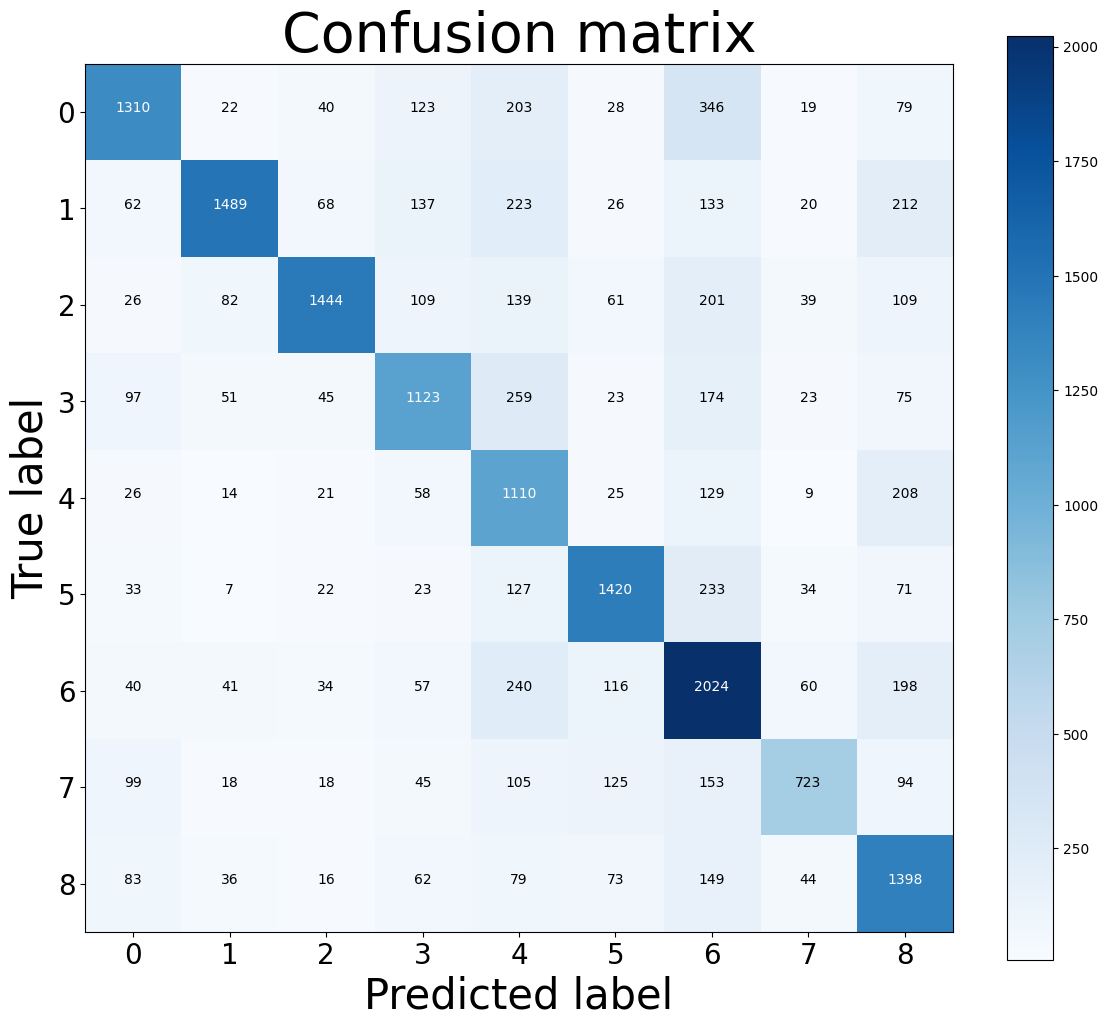

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, title = "Confusion matrix",
                          cmap = plt.cm.Blues, save_flg = False):
    classes = [str(i) for i in range(9)]
    labels = range(9)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=40)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    if save_flg:
        plt.savefig("./confusion_matrix.png")
    plt.show()
    
    
pred = model.predict(test_x)
y_pred = np.argmax(pred,1)
print(y_pred.shape, test_y.shape)
plot_confusion_matrix(test_y, y_pred, save_flg = True)


[[1310   22   40  123  203   28  346   19   79]
 [  62 1489   68  137  223   26  133   20  212]
 [  26   82 1444  109  139   61  201   39  109]
 [  97   51   45 1123  259   23  174   23   75]
 [  26   14   21   58 1110   25  129    9  208]
 [  33    7   22   23  127 1420  233   34   71]
 [  40   41   34   57  240  116 2024   60  198]
 [  99   18   18   45  105  125  153  723   94]
 [  83   36   16   62   79   73  149   44 1398]]
9
[['60.37%' '1.01%' '1.84%' '5.67%' '9.35%' '1.29%' '15.94%' '0.88%'
  '3.64%']
 ['2.62%' '62.83%' '2.87%' '5.78%' '9.41%' '1.10%' '5.61%' '0.84%'
  '8.95%']
 ['1.18%' '3.71%' '65.34%' '4.93%' '6.29%' '2.76%' '9.10%' '1.76%'
  '4.93%']
 ['5.19%' '2.73%' '2.41%' '60.05%' '13.85%' '1.23%' '9.30%' '1.23%'
  '4.01%']
 ['1.62%' '0.88%' '1.31%' '3.62%' '69.38%' '1.56%' '8.06%' '0.56%'
  '13.00%']
 ['1.68%' '0.36%' '1.12%' '1.17%' '6.45%' '72.08%' '11.83%' '1.73%'
  '3.60%']
 ['1.42%' '1.46%' '1.21%' '2.03%' '8.54%' '4.13%' '72.03%' '2.14%'
  '7.05%']
 ['7.17%' '1.30

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

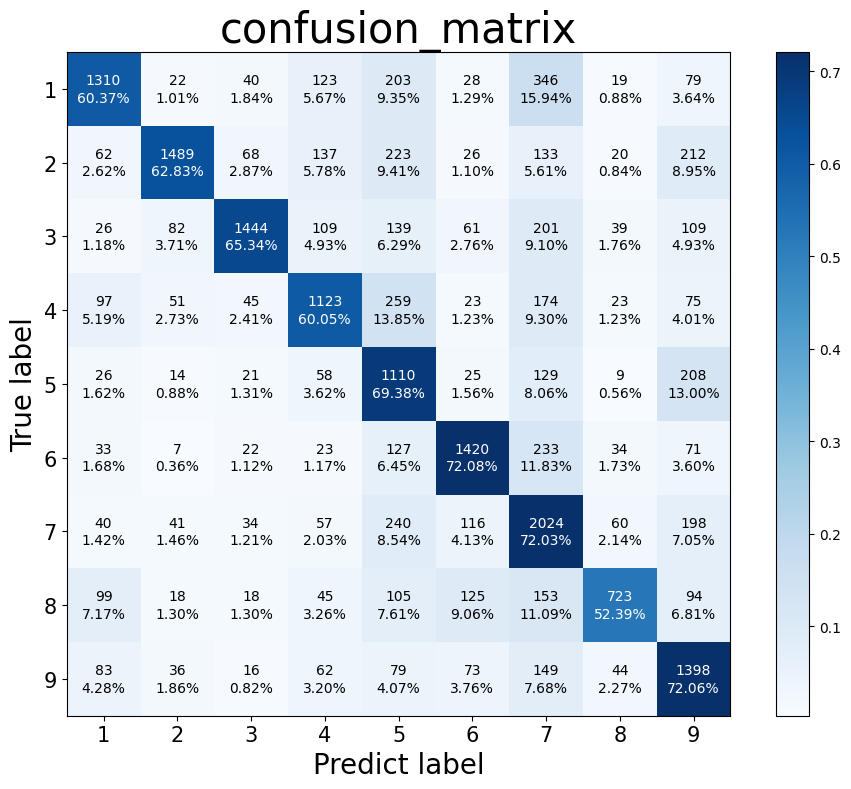

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import confusion_matrix

classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

pred = model.predict(test_x)
y_pred = np.argmax(pred,1)
labels = range(9)

cm = confusion_matrix(test_y, y_pred, labels=labels)
print(cm)

proportion = []
length = len(cm)
print(length)
for i in cm:
    for j in i:
        temp = j / (np.sum(i))
        proportion.append(temp)
# print(np.sum(cm[0]))
# print(proportion)
pshow = []
for i in proportion:
    pt = "%.2f%%" % (i * 100)
    pshow.append(pt)
proportion = np.array(proportion).reshape(length, length)  
pshow = np.array(pshow).reshape(length, length)

print(pshow)
rcParams.update()
plt.figure(figsize=(10, 8))
plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Blues)  
# (color：'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
# 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
plt.title('confusion_matrix',fontsize=30)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=15)
plt.yticks(tick_marks, classes, fontsize=15)

iters = np.reshape([[[i, j] for j in range(length)] for i in range(length)], (cm.size, 2))
for i, j in iters:
    if (i == j):
        plt.text(j, i - 0.12, format(cm[i, j]), va='center', ha='center', fontsize=10, color='white',
                 weight=5) 
        plt.text(j, i + 0.12, pshow[i, j], va='center', ha='center', fontsize=10, color='white')
    else:
        plt.text(j, i - 0.12, format(cm[i, j]), va='center', ha='center', fontsize=10)  # 显示对应的数字
        plt.text(j, i + 0.12, pshow[i, j], va='center', ha='center', fontsize=10)

plt.ylabel('True label', fontsize=20)
plt.xlabel('Predict label', fontsize=20)
plt.tight_layout()
plt.savefig('混淆矩阵.png')
plt.show()


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 44, 64)        14464     
                                                                 
 batch_normalization (BatchN  (None, 32, 44, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 44, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 22, 64)       0         
 )                                                               
                                                                 
 b11 (ResBlockLayer)         (None, 16, 22, 64)        132808    
                                                                 
 b12 (ResBlockLayer)         (None, 16, 22, 64)        1

# load model

In [ ]:
model.load_weights('./checkpoints/weights.16-0.6884.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 44, 64)        14464     
                                                                 
 batch_normalization (BatchN  (None, 32, 44, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 44, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 22, 64)       0         
 )                                                               
                                                                 
 b11 (ResBlockLayer)         (None, 16, 22, 64)        132808    
                                                                 
 b12 (ResBlockLayer)         (None, 16, 22, 64)        1

# representation distribution in PCA space

In [ ]:
trained_train_logits = np.zeros([128240,128])
trained_test_logits = np.zeros([18320,128])

# the one before last layer
from keras import backend as K
representation_layer = K.function(inputs=[model.layers[0].input], outputs=[model.get_layer('dense_1').output])

for i in range(70):
    representation = representation_layer([train_x[i*1832:(i+1)*1832]])
    representation = np.array(representation)[0]
    trained_train_logits[i*1832:(i+1)*1832,:]=representation
    
for i in range(10):
    representation = representation_layer([test_x[i*1832:(i+1)*1832]])
    representation = np.array(representation)[0]
    trained_test_logits[i*1832:(i+1)*1832,:]=representation
    
print(trained_train_logits.shape, trained_test_logits.shape)
print(type(trained_train_logits), type(trained_test_logits))
print(trained_train_logits, trained_test_logits)



(128240, 128) (18320, 128)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ -2.27193713   1.65883708   5.1305337  ...   5.30124044  -0.22474957
    4.32226706]
 [  3.74852085   1.72321498   1.24464846 ...   1.58453476   0.32721853
   -1.72831607]
 [ -0.69533843   2.20986605  -1.90553761 ...   4.12430668  -0.14623046
   -3.20707631]
 ...
 [  3.7608707   -2.4903307   -1.57740092 ...   6.03209209   6.1049304
   -8.99783993]
 [  3.66054416  -0.26731074  -7.02081633 ...  -1.58287764   1.98284388
  -11.31978035]
 [  1.28747702  -2.67974305  -4.74026155 ...  -2.63596773   1.56556702
   -7.20585251]] [[  1.23999155   5.79921055   0.13652782 ...  -0.73175615   0.08746839
    4.58307838]
 [  3.02166653  -0.47060373  -3.39945388 ...  -1.37289536   2.43577528
   -1.08826983]
 [  1.26965559  -0.67079246  -0.63369447 ...  -1.08449781   1.62246346
    3.38103199]
 ...
 [ -3.99411225  -5.3221736   -0.432836   ...  -5.60077     -9.62487507
   -5.06014681]
 [  6.01507854 -10.08361626  -3.02726722 ... 

In [38]:
trained_train_logits = scaler.fit_transform(trained_train_logits)
trained_test_logits = scaler.transform(trained_test_logits)

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

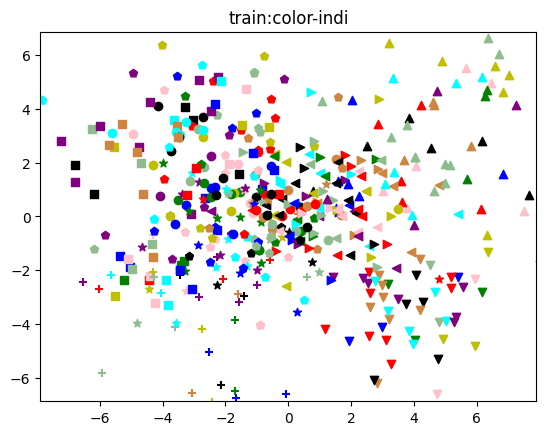

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

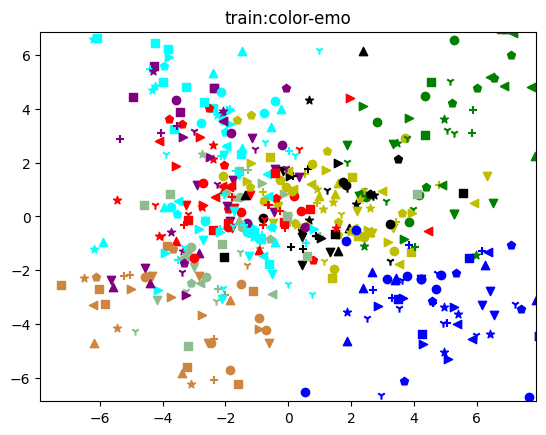

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

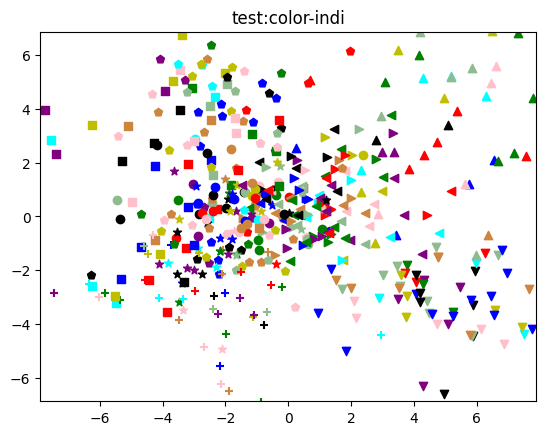

findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: Font family 'verdana' not found.
findfont: F

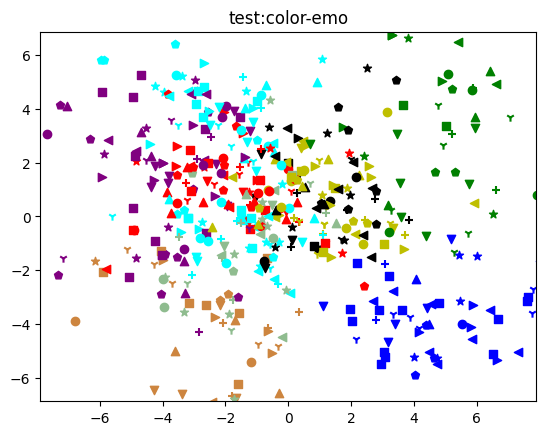

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
pca_data = pca.fit_transform(trained_train_logits)
colors = ['r','b','g','y','k','purple','aqua','darkseagreen','peru','pink']
markers = ['o','v','^','<','>','s','p','*','+','1']

# train set
# colored by subjects
for I in range(500):
    i = np.random.randint(len(train_x[0:18320]))
    plt.scatter(pca_data[i,0],pca_data[i,1],color=colors[indi_label[i]],marker=markers[train_y[i]])
plt.xlim([np.mean(pca_data[:,0])-2*np.std(pca_data[:,0]),np.mean(pca_data[:,0])+2*np.std(pca_data[:,0])])
plt.ylim([np.mean(pca_data[:,1])-2*np.std(pca_data[:,1]),np.mean(pca_data[:,1])+2*np.std(pca_data[:,1])])
plt.title("train:color-indi")
plt.savefig('train:color-indi.png')
plt.show()

# colored by emotions
for I in range(500):
    i = np.random.randint(len(train_x[0:18320]))
    plt.scatter(pca_data[i,0],pca_data[i,1],color=colors[train_y[i]],marker=markers[indi_label[i]])
plt.xlim([np.mean(pca_data[:,0])-2*np.std(pca_data[:,0]),np.mean(pca_data[:,0])+2*np.std(pca_data[:,0])])
plt.ylim([np.mean(pca_data[:,1])-2*np.std(pca_data[:,1]),np.mean(pca_data[:,1])+2*np.std(pca_data[:,1])])
plt.title("train:color-emo")
plt.savefig('train:color-emo.png')
plt.show()

# test set
# colored by subjects
for I in range(500):
    i = np.random.randint(len(test_x))
    plt.scatter(pca_data[i,0],pca_data[i,1],color=colors[indi_label_test[i]],marker=markers[test_y[i]])
plt.xlim([np.mean(pca_data[:,0])-2*np.std(pca_data[:,0]),np.mean(pca_data[:,0])+2*np.std(pca_data[:,0])])
plt.ylim([np.mean(pca_data[:,1])-2*np.std(pca_data[:,1]),np.mean(pca_data[:,1])+2*np.std(pca_data[:,1])])
plt.title("test:color-indi")
plt.savefig('test:color-indi.png')
plt.show()

# colored by emotions
for I in range(500):
    i = np.random.randint(len(test_x))
    plt.scatter(pca_data[i,0],pca_data[i,1],color=colors[test_y[i]],marker=markers[indi_label_test[i]])
plt.xlim([np.mean(pca_data[:,0])-2*np.std(pca_data[:,0]),np.mean(pca_data[:,0])+2*np.std(pca_data[:,0])])
plt.ylim([np.mean(pca_data[:,1])-2*np.std(pca_data[:,1]),np.mean(pca_data[:,1])+2*np.std(pca_data[:,1])])
plt.title("test:color-emo")
plt.savefig('test:color-emo.png')
plt.show()

# try dynamic conv

In [ ]:
from tensorflow.keras import layers

WEIGHT_DECAY=2e-4

def conv2d(kernel_size, stride, filters, kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY), padding="same", use_bias=False,
           kernel_initializer="he_normal", **kwargs):
    return layers.Conv2D(kernel_size=kernel_size, strides=stride, filters=filters, kernel_regularizer=kernel_regularizer, padding=padding,
                         use_bias=use_bias, kernel_initializer=kernel_initializer, **kwargs)

class Routing(layers.Layer):
    def __init__(self, out_channels, dropout_rate, temperature=30, **kwargs):
        super(Routing, self).__init__(**kwargs)
        self.avgpool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.fc = layers.Dense(units=out_channels)
        self.softmax = layers.Softmax()
        self.temperature = temperature

    def call(self, inputs, **kwargs):
        """
        :param inputs: (b, c, h, w)
        :return: (b, out_features)
        """
        out = self.avgpool(inputs)
        out = self.dropout(out)

        # refer to paper: https://arxiv.org/pdf/1912.03458.pdf
        out = self.softmax(self.fc(out) * 1.0 / self.temperature)
        return out


class CondConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), use_bias=True, num_experts=1, padding="same", **kwargs):
        super(CondConv2D, self).__init__(**kwargs)

        self.routing = Routing(out_channels=num_experts, dropout_rate=0.1, name="routing_layer")
        self.convs = []
        for _ in range(num_experts):
            self.convs.append(conv2d(filters=filters, stride=strides, kernel_size=kernel_size, use_bias=use_bias, padding=padding))

    def call(self, inputs, **kwargs):
        """
        :param inputs: (b, h, w, c)
        :return: (b, h_out, w_out, filters)
        """
        routing_weights = self.routing(inputs)
        feature = routing_weights[:, 0] * tf.transpose(self.convs[0](inputs), perm=[1, 2, 3, 0])
        for i in range(1, len(self.convs)):
            feature += routing_weights[:, i] * tf.transpose(self.convs[i](inputs), perm=[1, 2, 3, 0])
        feature = tf.transpose(feature, perm=[3, 0, 1, 2])
        return feature

In [44]:
class SEAttentionLayer2(Layer):
    def __init__(self,input_ch,reduce_ratio,*args,**kwargs):
        super(SEAttentionLayer2, self).__init__(*args,**kwargs)
        self.dense1 = CondConv2D(int(input_ch / reduce_ratio),kernel_size=(1,1))
        self.act1 = Activation("relu")
        self.dense2 = CondConv2D(input_ch,kernel_size=(1,1))
        self.act2 = Activation("sigmoid")
        self.input_ch  =  input_ch
    def call(self, inputs, *args, **kwargs):
        x = tf.reduce_mean(inputs,axis=[1,2],keepdims=True)
        x = self.act1(x)
        x = self.dense1(x)
        x = self.act2(x)
        x = self.dense2(x)
        outputs = x * inputs
        return outputs
    def build(self, input_shape):
        return input_shape
    
class ResBlockLayer2(Layer):
    def __init__(self,input_ch,se_ratio,dropout=0.1,*args,**kwargs):
        super(ResBlockLayer2,self).__init__(*args,**kwargs)
        self.conv1 = CondConv2D(input_ch,kernel_size=(4,4))
        self.bn1 = BatchNormalization()
        self.act1 = Activation("relu")
        self.drop1 = Dropout(dropout)
        self.conv2 = CondConv2D(input_ch,kernel_size=(4,4))
        self.bn2 = BatchNormalization()
        self.se = SEAttentionLayer2(input_ch,se_ratio)
    def call(self,inputs,*args,**kwargs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        outputs = x + inputs
        return outputs

def build_resnet_model2(seq_len,input_ch):
    model = Sequential([
        InputLayer((seq_len,input_ch,1)),
        CondConv2D(64, kernel_size=(15,15)),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2),(2,2),"same"),
        ResBlockLayer2(64,8,name="b11"),
        ResBlockLayer2(64,8,name="b12"),
        CondConv2D(128,kernel_size=7,strides=(2,2)),

        ResBlockLayer2(128,8,name="b21"),
        ResBlockLayer2(128,8,name="b22"),
        CondConv2D(196,kernel_size=7,strides=(2,2)),

        ResBlockLayer2(196,8,name="b31"),
        ResBlockLayer2(196,8,name="b32"),
        CondConv2D(256, kernel_size=7,strides=(2,2)),
        ResBlockLayer2(256, 8,name="b41"),
        ResBlockLayer2(256, 8,name="b42"),

        GlobalAveragePooling2D(),
        Dense(512,activation="relu"),
        Dense(128),
        Dense(9)
    ])
    return model

In [45]:
model2 = build_resnet_model2(32,44)

In [46]:
model2.compile(optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'],loss=SparseCategoricalCrossentropy(from_logits=True))

if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
    
ck_callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_f1:.4f}.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=0)

model2.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=10,shuffle=True,callbacks=[Metrics(valid_data=(test_x, test_y)),
                     ck_callback,
                     tb_callback])



Epoch 1/10
4008/4008 [==============================] - 998s 242ms/step - loss: 3.1082 - accuracy: 0.4460 - val_loss: 4.2203 - val_accuracy: 0.3031
 — val_f1: 0.291996 — val_precision: 0.309551 — val_recall: 0.294043

Epoch 00001: val_f1 improved from -inf to 0.29200, saving model to ./checkpoints/weights.01-0.2920.hdf5
Epoch 2/10
4008/4008 [==============================] - 1117s 279ms/step - loss: 2.1436 - accuracy: 0.6601 - val_loss: 4.3808 - val_accuracy: 0.3412
 — val_f1: 0.333631 — val_precision: 0.344723 — val_recall: 0.337823

Epoch 00002: val_f1 improved from 0.29200 to 0.33363, saving model to ./checkpoints/weights.02-0.3336.hdf5
Epoch 3/10
4008/4008 [==============================] - 1198s 299ms/step - loss: 1.6435 - accuracy: 0.7508 - val_loss: 4.8870 - val_accuracy: 0.3784
 — val_f1: 0.375690 — val_precision: 0.407094 — val_recall: 0.378214

Epoch 00003: val_f1 improved from 0.33363 to 0.37569, saving model to ./checkpoints/weights.03-0.3757.hdf5
Epoch 4/10
4008/4008 [====